<a href="https://colab.research.google.com/github/Sayandip2023/SAP-SIT-Hackathon/blob/main/Working_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Fetching the dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c asap-sas
!unzip asap-sas.zip
# Upload your kaggle.json file in the Google Colab runtime and then run this cell

 71% 17.0M/24.0M [00:00<00:00, 40.3MB/s]
100% 24.0M/24.0M [00:00<00:00, 50.5MB/s]
Archive:  asap-sas.zip
  inflating: Data_Set_Descriptions.zip  
  inflating: Guidelines for Transcribing Student Essays.docx  
  inflating: Training_Materials.zip  
  inflating: bag_of_words_benchmark.csv  
  inflating: length_benchmark.csv    
  inflating: private_leaderboard.tsv  
  inflating: public_leaderboard.tsv  
  inflating: public_leaderboard_rel_2.tsv  
  inflating: public_leaderboard_solution.csv  
  inflating: test.csv                
  inflating: train.tsv               
  inflating: train_rel_2.tsv         


## Importing the necessary libraries

In [ ]:
import torch
from transformers import BartForSequenceClassification, BartTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import pandas as pd
import nltk
from nltk.corpus import stopwords

## Downloading NLTK stopwords

In [ ]:
# Download NLTK stopwords
nltk.download('stopwords')

## Checking for CUDA (GPU) Availability

In [ ]:
# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

## Loading BART Model and Tokenizer

In [ ]:
# Load BART model and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
num_labels = 4
model = BartForSequenceClassification.from_pretrained('facebook/bart-large-cnn', num_labels=num_labels)
model.to(device)

## Loading Data

In [ ]:
# Load data from .tsv file
data = pd.read_csv("/content/train.tsv", sep='\t')
essays = data['EssayText'].tolist()
scores = data['Score1'].tolist()

## Defining Dataset and Data Loader

In [ ]:
# Define dataset and data loader
class EssayDataset(Dataset):
    def __init__(self, essays, scores, tokenizer, max_len=512):
        self.essays = essays
        self.scores = scores
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.stop_words = set(stopwords.words('english'))  # Load English stop words

    def remove_stopwords(self, text):
        tokens = text.split()
        filtered_tokens = [word for word in tokens if word.lower() not in self.stop_words]
        return ' '.join(filtered_tokens)

    def __len__(self):
        return len(self.essays)

    def __getitem__(self, idx):
        essay = str(self.essays[idx])
        essay = self.remove_stopwords(essay)  # Remove stop words
        score = self.scores[idx]
        encoding = self.tokenizer(essay, truncation=True, max_length=self.max_len, padding='max_length', return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(score, dtype=torch.long)  # Use torch.long for classification labels
        }

## Data Splitting

In [ ]:
# Split data into train and test sets
train_essays, test_essays, train_scores, test_scores = train_test_split(essays, scores, test_size=0.2, random_state=42)

## Defining Dataset and Data Loader with Modified Scores

In [ ]:
# Define dataset and data loader with modified scores
train_dataset = EssayDataset(train_essays, train_scores, tokenizer)
test_dataset = EssayDataset(test_essays, test_scores, tokenizer)

## Defining Optimizer and Loss Function

In [ ]:
# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

## Mixed Precision Training Setup

In [ ]:
# Mixed precision training
scaler = torch.cuda.amp.GradScaler()

## Model Training and Evaluation

In [ ]:
# Training loop
model.train()
for epoch in range(10):
    running_loss = 0.0
    total_correct_train = 0
    total_samples_train = 0

    optimizer.zero_grad()
    for i, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/10')):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.cuda.amp.autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        running_loss += loss.item()

        _, predicted_scores = torch.max(outputs.logits, dim=1)
        total_correct_train += (predicted_scores == labels).sum().item()
        total_samples_train += labels.size(0)

        if (i + 1) % 8 == 0:  # Accumulate gradients every 8 batches
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

    train_accuracy = total_correct_train / total_samples_train
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_accuracy}')

# Save the trained model
model.save_pretrained("/content")

# Evaluate the model on test data
total_correct = 0
total_samples = 0
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating on Test Data'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_scores = torch.argmax(outputs.logits, dim=1)
        total_correct += (predicted_scores == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
print(f'Test Accuracy: {accuracy}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using device: cuda


Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large-cnn and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10: 100%|██████████| 1721/1721 [19:18<00:00,  1.49it/s]


Epoch 1, Loss: 0.8431720471638431, Train Accuracy: 0.623465310570287


Epoch 2/10: 100%|██████████| 1721/1721 [19:16<00:00,  1.49it/s]


Epoch 2, Loss: 0.6559624796271116, Train Accuracy: 0.7139847439157283


Epoch 3/10: 100%|██████████| 1721/1721 [19:10<00:00,  1.50it/s]


Epoch 3, Loss: 0.5635105301861427, Train Accuracy: 0.7583000363240102


Epoch 4/10: 100%|██████████| 1721/1721 [19:09<00:00,  1.50it/s]


Epoch 4, Loss: 0.439484035099474, Train Accuracy: 0.8151107882310207


Epoch 5/10: 100%|██████████| 1721/1721 [19:09<00:00,  1.50it/s]


Epoch 5, Loss: 0.4166520974235712, Train Accuracy: 0.8261532873229205


Epoch 6/10: 100%|██████████| 1721/1721 [19:08<00:00,  1.50it/s]


Epoch 6, Loss: 0.28907837753358934, Train Accuracy: 0.8843443516164184


Epoch 7/10: 100%|██████████| 1721/1721 [19:08<00:00,  1.50it/s]


Epoch 7, Loss: 0.22142207015572005, Train Accuracy: 0.912459135488558


Epoch 8/10: 100%|██████████| 1721/1721 [19:10<00:00,  1.50it/s]


Epoch 8, Loss: 0.17392718632484178, Train Accuracy: 0.9320741009807483


Epoch 9/10: 100%|██████████| 1721/1721 [19:08<00:00,  1.50it/s]


Epoch 9, Loss: 0.13798555834808715, Train Accuracy: 0.9487831456592808


Epoch 10/10:  60%|█████▉    | 1029/1721 [11:26<07:35,  1.52it/s]

## Finding Model Performance on Test Data and Metrics Calculation

In [ ]:
# Evaluate the model on test data
model.eval()
total_correct = 0
total_samples = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating on Test Data'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_scores = torch.argmax(outputs.logits, dim=1)
        total_correct += (predicted_scores == labels).sum().item()
        total_samples += labels.size(0)
        all_predictions.extend(predicted_scores.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = total_correct / total_samples
print(f'Test Accuracy: {accuracy}')

# Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)
mae = mean_absolute_error(all_labels, all_predictions)
rmse = np.sqrt(mean_squared_error(all_labels, all_predictions))

print(f'Test MAE: {mae}')
print(f'Test RMSE: {rmse}')

## Extended Analysis of True Score and Predicted Score Distributions and Errors

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1', '2': 'LABEL_2', '3': 'LABEL_3'}. The number of labels wil be overwritten to 4.
Evaluating on Test Data: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Mean Absolute Error (MAE): 1.0431226928614907
Mean Squared Error (MSE): 1.9577084024721019


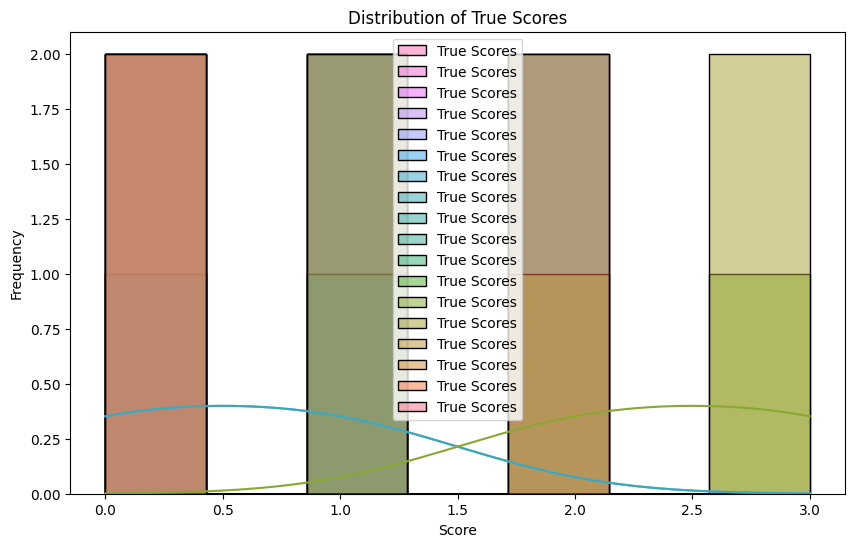

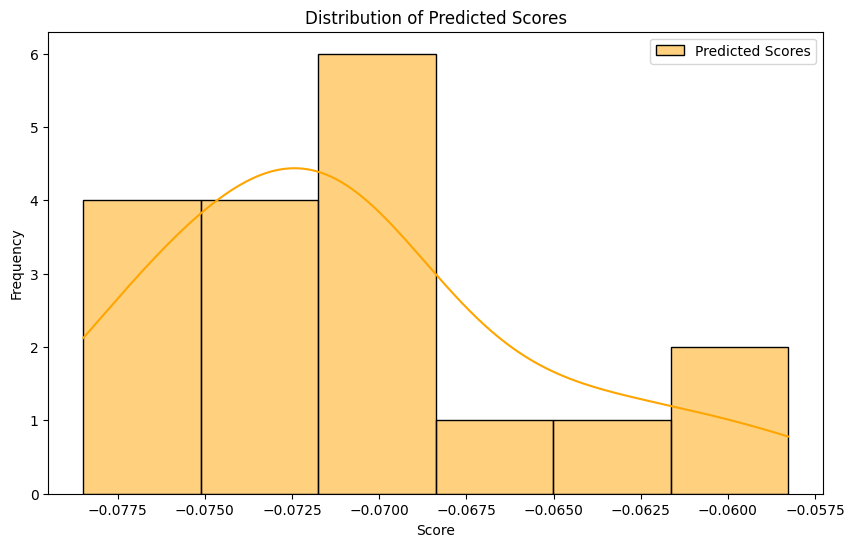

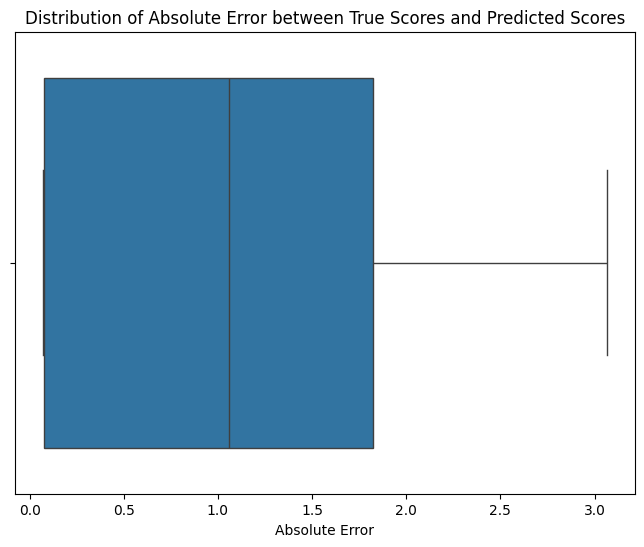

In [ ]:
test_dataset = EssayDataset(test_data['EssayText'].tolist(), [(s1, s2) for s1, s2 in zip(test_data['Score1'].tolist(), test_data['Score2'].tolist())], tokenizer)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Define device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluate the model on test data
predicted_scores = []
true_scores = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating on Test Data'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['score'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_score = outputs.last_hidden_state[:, 0]  # Take the first token's hidden state as representation
        predicted_score = torch.mean(predicted_score, dim=1)  # Average over all hidden states
        predicted_score = torch.squeeze(predicted_score)  # Squeeze the tensor to remove extra dimensions

        predicted_scores.extend(predicted_score.cpu().numpy())
        true_scores.extend(labels.cpu().numpy())

# Combine Score1 and Score2 into a single target score
true_scores_combined = [(s1 + s2) / 2 for s1, s2 in zip(test_data['Score1'].tolist(), test_data['Score2'].tolist())]

# Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = mean_absolute_error(true_scores_combined, predicted_scores)
mse = mean_squared_error(true_scores_combined, predicted_scores)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Plot the distribution of true scores and predicted scores
plt.figure(figsize=(10, 6))
sns.histplot(true_scores, kde=True, color='blue', label='True Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of True Scores')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(predicted_scores, kde=True, color='orange', label='Predicted Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Scores')
plt.legend()
plt.show()

# Plot the boxplot of the absolute error between true scores and predicted scores
absolute_error = np.abs(np.array(true_scores_combined) - np.array(predicted_scores))

plt.figure(figsize=(8, 6))
sns.boxplot(x=absolute_error)
plt.xlabel('Absolute Error')
plt.title('Distribution of Absolute Error between True Scores and Predicted Scores')
plt.show()


## Residual Plot, Scatter Plot, MAE, MSE, Pearson Correlation Coefficient

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1', '2': 'LABEL_2', '3': 'LABEL_3'}. The number of labels wil be overwritten to 4.
Evaluating on Test Data: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


Mean Absolute Error (MAE): 1.0431226928614907
Mean Squared Error (MSE): 1.9577084024721019
R-squared: -1.2393557719363146
Pearson correlation coefficient: 0.4685750489881725


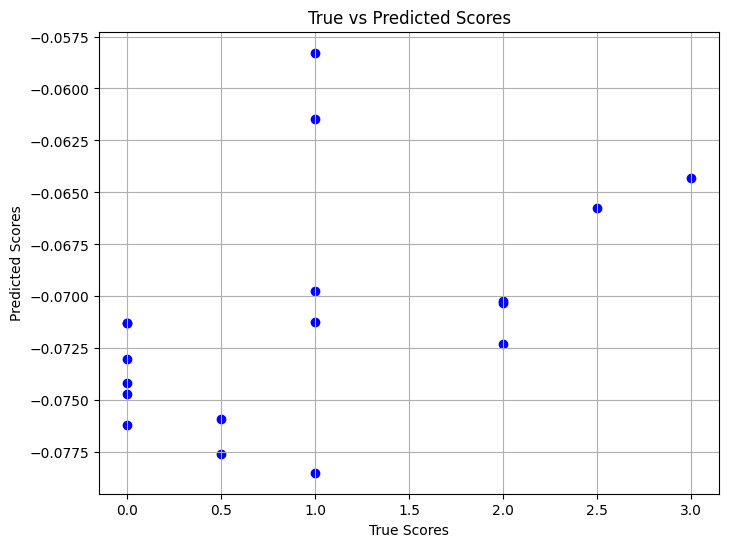

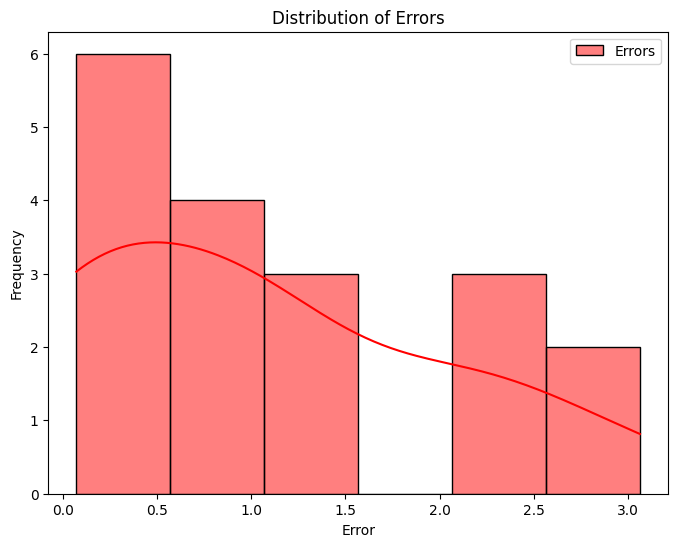

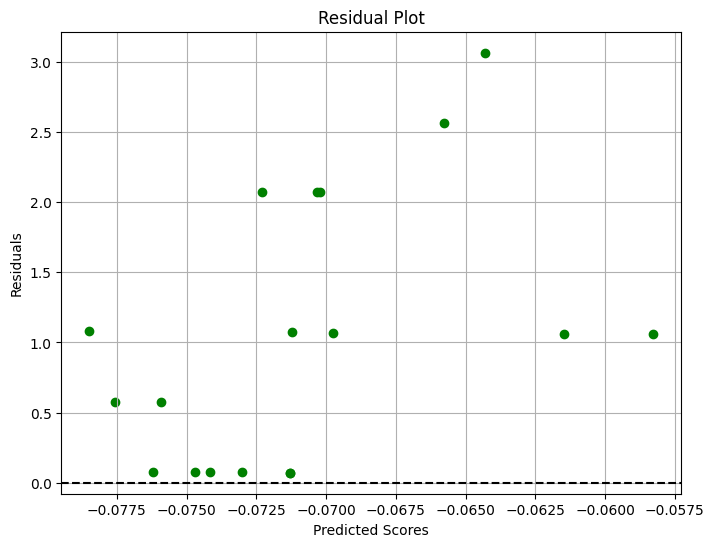

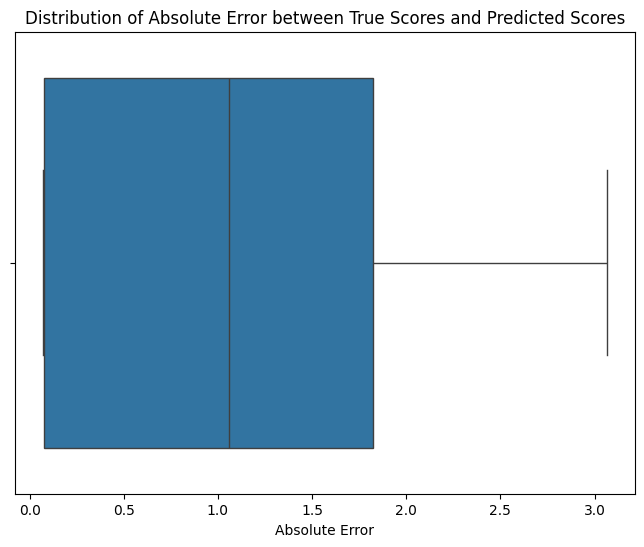

In [ ]:
# Evaluate the model on test data
predicted_scores = []
true_scores = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating on Test Data'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['score'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_score = outputs.last_hidden_state[:, 0]  # Take the first token's hidden state as representation
        predicted_score = torch.mean(predicted_score, dim=1)  # Average over all hidden states
        predicted_score = torch.squeeze(predicted_score)  # Squeeze the tensor to remove extra dimensions

        predicted_scores.extend(predicted_score.cpu().numpy())
        true_scores.extend(labels.cpu().numpy())

# Combine Score1 and Score2 into a single target score
true_scores_combined = [(s1 + s2) / 2 for s1, s2 in true_scores]

# Calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), R-squared, and Pearson correlation coefficient
mae = mean_absolute_error(true_scores_combined, predicted_scores)
mse = mean_squared_error(true_scores_combined, predicted_scores)
r_squared = r2_score(true_scores_combined, predicted_scores)
pearson_corr, _ = pearsonr(true_scores_combined, predicted_scores)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r_squared}")
print(f"Pearson correlation coefficient: {pearson_corr}")

# Plot the scatter plot of true scores vs predicted scores
plt.figure(figsize=(8, 6))
plt.scatter(true_scores_combined, predicted_scores, color='b')
plt.xlabel('True Scores')
plt.ylabel('Predicted Scores')
plt.title('True vs Predicted Scores')
plt.grid(True)
plt.show()

# Plot the distribution of errors
errors = np.array(true_scores_combined) - np.array(predicted_scores)
plt.figure(figsize=(8, 6))
sns.histplot(errors, kde=True, color='r', label='Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Errors')
plt.legend()
plt.show()

# Plot the residual plot
plt.figure(figsize=(8, 6))
plt.scatter(predicted_scores, errors, color='g')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted Scores')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

# Plot the boxplot of the absolute error between true scores and predicted scores
absolute_error = np.abs(np.array(true_scores_combined) - np.array(predicted_scores))
plt.figure(figsize=(8, 6))
sns.boxplot(x=absolute_error)
plt.xlabel('Absolute Error')
plt.title('Distribution of Absolute Error between True Scores and Predicted Scores')
plt.show()


## Explainability in Essay Grading from the point of view of Transformer: This will output the tokens contributing most impactfully to the predicted essay score

In [ ]:
# Evaluate the model on test data and generate explanations
model.eval()
explanations = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating on Test Data'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_scores = torch.argmax(outputs.logits, dim=1)

        # Generate explanations for each essay
        for i in range(len(batch)):
            essay_text = tokenizer.decode(batch['input_ids'][i], skip_special_tokens=True)
            true_score = batch['labels'][i]
            predicted_score = predicted_scores[i]
            explanation = generate_explanation(essay_text, true_score, predicted_score)  # Your explanation generation function
            explanations.append({'Essay': essay_text, 'True Score': true_score.item(), 'Predicted Score': predicted_score.item(), 'Explanation': explanation})

# Display explanations
for i, explanation in enumerate(explanations):
    print(f"Essay {i+1}:")
    print(f"True Score: {explanation['True Score']}, Predicted Score: {explanation['Predicted Score']}")
    print("Essay Text:", explanation['Essay'])
    print("Explanation:", explanation['Explanation'])
    print()

## Explainability in Essay Grading for End-Users: This will generate feedback regarding the input essay and what they can improve

In [ ]:
# Evaluate the model on test data
total_correct = 0
total_samples = 0
explanations = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating on Test Data'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
        predicted_scores = torch.argmax(outputs.logits, dim=1)

        # Explanation generation based on attention
        attentions = outputs.encoder_attentions  # Extract encoder attentions
        for i in range(len(predicted_scores)):
            attention = attentions[-1][i].mean(dim=1)  # Mean attention across heads and layers
            weighted_tokens = torch.matmul(attention, input_ids[i].float())  # Weighted sum of input tokens based on attention
            explanation_tokens = tokenizer.convert_ids_to_tokens(weighted_tokens.cpu().numpy())
            explanation = ' '.join(explanation_tokens)
            explanations.append((explanation, predicted_scores[i].item()))

        total_correct += (predicted_scores == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
print(f'Test Accuracy: {accuracy}')

for i, (explanation, score) in enumerate(explanations):
    # Define narrative explanations based on the predicted score
    if score == 0:
        narrative_explanation = "This essay lacks clear organization and fails to address key points. It lacks depth and coherence, resulting in a low score."
    elif score == 1:
        narrative_explanation = "The essay demonstrates some understanding of the topic but lacks depth and originality. It could benefit from stronger supporting arguments and clearer expression."
    elif score == 2:
        narrative_explanation = "This essay presents a decent analysis of the topic with some original insights. However, it could be more coherent and persuasive to achieve a higher score."
    elif score == 3:
        narrative_explanation = "The essay is well-structured and presents a compelling argument supported by evidence. It demonstrates a deep understanding of the topic and effectively engages the reader."

    print(f"Prediction {i+1}:")
    print(f"Narrative Explanation: {narrative_explanation}")
    print(f"Predicted Score: {score}\n")